In [23]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Extract Reduced Frames from Videos
def extract_reduced_frames(video_dir, output_dir, interval=10):
    """
    Extract frames from videos at a specific interval to reduce dataset size.
    :param video_dir: Path to the directory containing videos.
    :param output_dir: Path to the directory to save the extracted frames.
    :param interval: Number of seconds between each extracted frame.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for video_file in os.listdir(video_dir):
        video_path = os.path.join(video_dir, video_file)
        if not video_file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue
        
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second of the video
        frame_interval = int(fps * interval)  # Calculate frame interval in terms of frame count
        
        frame_count = 0
        success, frame = cap.read()
        while success:
            if frame_count % frame_interval == 0:  # Extract frame at the given interval
                frame_filename = os.path.join(output_dir, f"{os.path.splitext(video_file)[0]}_frame_{frame_count}.jpg")
                cv2.imwrite(frame_filename, frame)
            success, frame = cap.read()
            frame_count += 1
        
        cap.release()
    print(f"Reduced frames extracted and saved in {output_dir}")

# Define paths
real_videos_path = r'C:\Users\yakup\Desktop\Special Dataset\DFD_original sequences'
fake_videos_path = r'C:\Users\yakup\Desktop\Special Dataset\DFD_manipulated_sequences'

real_frames_path = r'C:\Users\yakup\Desktop\Special Dataset\Frames\Real'
fake_frames_path = r'C:\Users\yakup\Desktop\Special Dataset\Frames\Fake'

# Extract frames with an interval of 5 seconds
extract_reduced_frames(real_videos_path, real_frames_path, interval=5)
extract_reduced_frames(fake_videos_path, fake_frames_path, interval=5)

# Step 2: Dataset Preparation
frame_dataset_path = r'C:\Users\yakup\Desktop\Special Dataset\Frames'



Reduced frames extracted and saved in C:\Users\yakup\Desktop\Special Dataset\Frames\Real
Reduced frames extracted and saved in C:\Users\yakup\Desktop\Special Dataset\Frames\Fake


c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model...
Epoch [1/10], Loss: 0.3925, Accuracy: 0.8732
Epoch [2/10], Loss: 0.3786, Accuracy: 0.8771
Epoch [3/10], Loss: 0.3782, Accuracy: 0.8770
Epoch [4/10], Loss: 0.3757, Accuracy: 0.8776
Epoch [5/10], Loss: 0.3759, Accuracy: 0.8774
Epoch [6/10], Loss: 0.3751, Accuracy: 0.8773
Epoch [7/10], Loss: 0.3743, Accuracy: 0.8779
Epoch [8/10], Loss: 0.3734, Accuracy: 0.8779
Epoch [9/10], Loss: 0.3730, Accuracy: 0.8779
Epoch [10/10], Loss: 0.3733, Accuracy: 0.8780
Evaluating model...


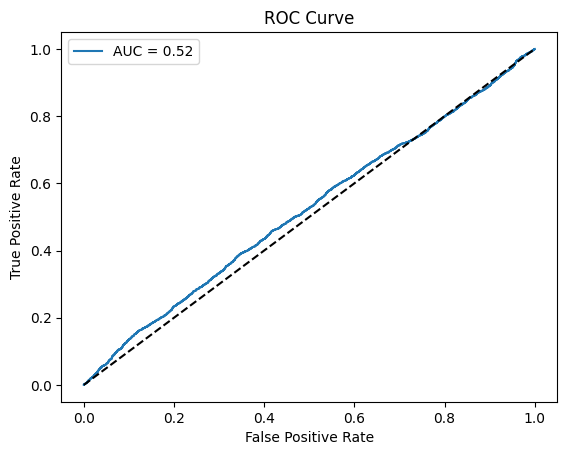

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     20204
           1       0.00      0.00      0.00      2808

    accuracy                           0.88     23012
   macro avg       0.44      0.50      0.47     23012
weighted avg       0.77      0.88      0.82     23012

Confusion Matrix:
[[20204     0]
 [ 2808     0]]
Model saved as resnet_deepfake_detector.pth


c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Set paths
real_path = r"C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames\\Real"
fake_path = r"C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames\\Fake"

# Parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset and DataLoader
data = datasets.ImageFolder(root=os.path.dirname(real_path), transform=transform)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

# Model selection
def get_model(model_name):
    if model_name == "resnet":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 2)
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    else:
        raise ValueError("Model not supported")
    return model

# Training function
def train_model(model, criterion, optimizer, num_epochs):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader):.4f}, Accuracy: {correct/total:.4f}")

    return model

# Evaluation function
def evaluate_model(model):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_probs.extend(probs[:, 1].cpu().numpy())

    # ROC and AUC
    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # Classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Main script
if __name__ == "__main__":
    model_name = "resnet"  # Choose from: "resnet", "vgg16", "efficientnet"
    model = get_model(model_name)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Training model...")
    model = train_model(model, criterion, optimizer, num_epochs)

    print("Evaluating model...")
    evaluate_model(model)

    # Save model
    torch.save(model.state_dict(), f"{model_name}_deepfake_detector.pth")
    print(f"Model saved as {model_name}_deepfake_detector.pth")
